# Baseline

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.cm as cm
import numpy as np

In [2]:
def calculate_size(size, kernel_size, stride):
    return (size - kernel_size) // stride + 1

In [46]:
class BaseLineModel(nn.Module):
    def __init__(self, kernel_num = 10, kernel_size = 5, dropout_rate = 0.5, pool_size = 2, activation_func = F.relu, hidden_nodes = 50, training_epoch = 5, batch_size = 64):
        super(BaseLineModel, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.pool_size = pool_size
        self.activation_func = activation_func
        self.hidden_nodes = hidden_nodes

        self.fc_input_size = calculate_size(28, self.kernel_size, 1)
        self.fc_input_size = calculate_size(self.fc_input_size, self.pool_size, self.pool_size)
        self.fc_input_size = calculate_size(self.fc_input_size, self.kernel_size, 1)
        self.fc_input_size = calculate_size(self.fc_input_size, 2, 2)
        self.fc_input_size = 20 * self.fc_input_size * self.fc_input_size
        print(f'first full connected layer input size: {self.fc_input_size}')

        self.n_epochs = training_epoch
        self.batch_size_train = batch_size
        self.batch_size_test = 1000
        self.learning_rate = 0.01
        self.momentum = 0.5
        self.log_interval = 10
        self.random_seed = 42

        torch.backends.cudnn.enabled = False
        torch.manual_seed(self.random_seed)

        # load the training dataset and test dataset
        self.train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True,
                                                        transform=torchvision.transforms.Compose([
                                                            torchvision.transforms.ToTensor(),
                                                            torchvision.transforms.Normalize(
                                                                (0.1307,), (0.3081,))
                                                        ]))
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size_train)
        self.test_dataset = torchvision.datasets.MNIST('../data', train=False, download=True,
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToTensor(),
                                                           torchvision.transforms.Normalize(
                                                               (0.1307,), (0.3081,))
                                                       ]))
        self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size_test)

        # define the layers
        self.conv1 = nn.Conv2d(1, self.kernel_num, kernel_size=(self.kernel_size, self.kernel_size))
        self.conv2 = nn.Conv2d(self.kernel_num, 20, kernel_size=(self.kernel_size, self.kernel_size))
        self.conv2_drop = nn.Dropout2d(p=self.dropout_rate)
        self.fc1 = nn.Linear(self.fc_input_size, self.hidden_nodes)
        self.fc2 = nn.Linear(self.hidden_nodes, 10)

    def forward(self, x):
        """
        computes a forward pass for the network
        :param x: feed data
        :return: 10 values indicating the confidence of the data towards labels
        """
        x = self.activation_func(F.max_pool2d(self.conv1(x), self.pool_size))
        x = self.activation_func(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.fc_input_size)
        x = self.activation_func(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [4]:
def train_network(network, epoch, train_losses, train_counter, model_pth, opt_pth):
    """
    Train the network on the training dataset, calculate the loss values.
    :param network: the network that is during training
    :param epoch: the training epoch
    :param train_losses: the training loss values in a list
    :param train_counter: the counter for training
    """
    optimizer = optim.SGD(network.parameters(), lr=network.learning_rate,
                          momentum=network.momentum)

    network.train()
    for batch_idx, (data, target) in enumerate(network.train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % network.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(network.train_loader.dataset),
                       100. * batch_idx / len(network.train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(network.train_loader.dataset)))
            torch.save(network.state_dict(), f'results/{model_pth}.pth')
            torch.save(optimizer.state_dict(), f'results/{opt_pth}.pth')


def test_network(network, test_losses):
    """
    Test the network performance on the test dataset, calculate the corresponding loss.
    :param network: the network that is during training
    :param test_losses: the loss values on the test dataset
    """
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in network.test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(network.test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(network.test_loader.dataset),
        100. * correct / len(network.test_loader.dataset)))
    return correct

def train_process(network, model_pth, opt_pth):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i * len(network.train_loader.dataset) for i in range(network.n_epochs + 1)]
    accuracies = []

    correct_num = test_network(network, test_losses)
    accuracies.append(correct_num / len(network.test_loader.dataset))
    total_time = 0
    train_start_time = time.time()
    for epoch in range(1, network.n_epochs + 1):
        train_network(network, epoch, train_losses, train_counter, model_pth, opt_pth)
        correct_num = test_network(network, test_losses)
        accuracies.append(correct_num / len(network.test_loader.dataset))
        print(f'Epoch {epoch} takes: {time.time() - train_start_time}s\n')
        total_time += (time.time() - train_start_time)

    print(f'Average time per epoch: {total_time / network.n_epochs}s')
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()
    return train_losses, train_counter, test_counter, test_losses, accuracies, total_time, total_time / network.n_epochs

first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\649405604.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\stard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335315
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299947
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291813
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.289917
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.286746
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.280502
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.270755
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.245888
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.201029
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.232131
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.203217
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.197560
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.150122
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.038775
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.913650
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.937729
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.918656
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.792339
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.780283
Train Epoch: 1 [12160/6

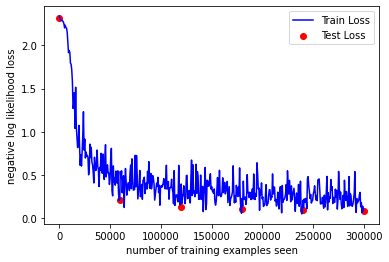

([2.3353145122528076,
  2.2999470233917236,
  2.291813373565674,
  2.289917469024658,
  2.286745548248291,
  2.2805016040802,
  2.27075457572937,
  2.245887517929077,
  2.201029062271118,
  2.232130527496338,
  2.203216791152954,
  2.1975598335266113,
  2.1501224040985107,
  2.0387752056121826,
  1.913649559020996,
  1.9377292394638062,
  1.9186564683914185,
  1.7923386096954346,
  1.7802832126617432,
  1.7144818305969238,
  1.5792450904846191,
  1.269954800605774,
  1.3131014108657837,
  1.452376365661621,
  1.039747714996338,
  1.5145587921142578,
  1.0623748302459717,
  0.9400245547294617,
  0.8168942332267761,
  0.831852376461029,
  1.0739333629608154,
  0.8545708060264587,
  0.6116294860839844,
  0.7354785203933716,
  0.60369473695755,
  0.7767595648765564,
  0.9519156217575073,
  1.231558084487915,
  0.7878378033638,
  0.9148374199867249,
  0.6966639757156372,
  0.7667309641838074,
  0.7190701365470886,
  0.7275977730751038,
  0.7009578943252563,
  0.5024852752685547,
  0.5750345

In [5]:
    baseline_model = BaseLineModel()
    train_process(baseline_model, 'baseline', 'baseline_opt')

---
# Experiment-1: The size of the convolution filters
#### Hypothesis
Larger kernel should learn more features and more translation-invariant than small kernels, which should lead to bigger accuracy. However, when the kernel size is approaching the image size, the accuracy should decrease due to the lack of information.
#### Observation
The accuracy plot shows the model with kernel size as 6 performs best out of the six models. The accuracy of those models increases as the kernel size increases from 2 to 6. Then the model with convolutional kernel size as 7 performs worse than the those with kernels size from 3 to 6, which  indicates kernel size as 6 in this task may be the optimal choice.

first full connected layer input size: 720
first full connected layer input size: 500
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 180
first full connected layer input size: 80
2 2_opt


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\649405604.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2927, Accuracy: 1476/10000 (15%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.276106
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.297755
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.267977
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251389
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.186069
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.174309
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.079593
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.040155
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.998853
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.984960
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.711460
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.813723
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.694276
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.478993
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.290854
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.216749
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.345958
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303415
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.134991
Train Epoch: 1 [12160

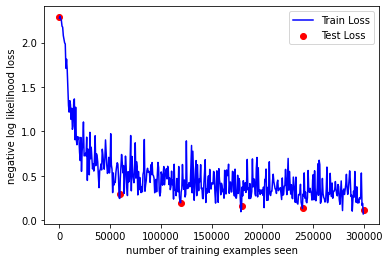

3 3_opt

Test set: Avg. loss: 2.3116, Accuracy: 953/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346908
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287597
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299248
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.240806
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.245672
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.222173
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.172734
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.164049
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.162039
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.080024
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.819869
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.884437
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.813591
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.748868
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.424297
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.212580
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.666744
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.270359
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.387295
Train Epoch: 1

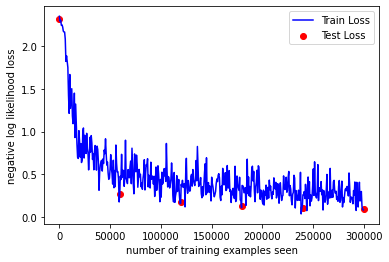

4 4_opt

Test set: Avg. loss: 2.3026, Accuracy: 996/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333906
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.309104
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.320174
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.264701
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.296666
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.257295
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.214614
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.255530
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.187298
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.126913
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.112784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.142426
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.965693
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.884693
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.501933
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.854818
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.738665
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.661468
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.442574
Train Epoch: 1

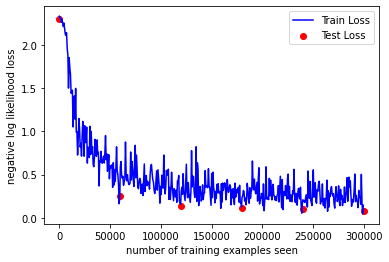

5 5_opt

Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324080
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.331326
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.267623
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.274755
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.292955
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.278762
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.297213
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.248072
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.251166
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.194319
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.165383
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.185192
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.077884
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.061612
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.928622
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.961286
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.862857
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.604769
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.601666
Train Epoch: 1 

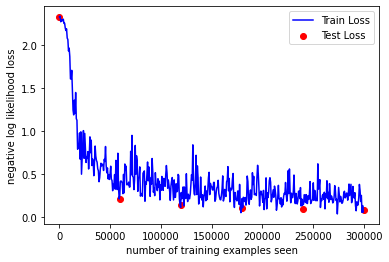

6 6_opt

Test set: Avg. loss: 2.3049, Accuracy: 1009/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299916
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.374628
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.279204
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279385
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.250390
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.241595
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.266898
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.223493
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.225246
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.181542
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.102268
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.082001
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.887172
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.002669
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.676076
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.646889
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.761001
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.622710
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.738462
Train Epoch: 

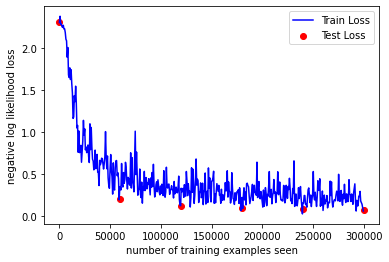

7 7_opt

Test set: Avg. loss: 2.3100, Accuracy: 1014/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.380090
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.292988
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.303222
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.293032
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.240778
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.249728
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.138611
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.193666
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.145658
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.168994
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.965461
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.966029
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.987983
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.818626
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.740403
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.968712
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.641465
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.505094
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.734389
Train Epoch: 

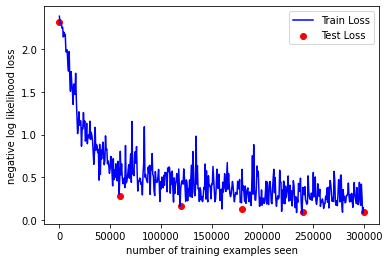

In [6]:
first_experiment_models = [BaseLineModel(kernel_size=i) for i in range(2, 8, 1)]
first_experiment_test_losses = []
first_experiment_accuracies = []
first_experiment_avg_time = []
for model in first_experiment_models:
    print(str(model.kernel_size), str(model.kernel_size) + '_opt')
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp1_{model.kernel_size}', f'exp1_{model.kernel_size}_opt')
    first_experiment_test_losses.append(test_losses)
    first_experiment_accuracies.append(accuracies)
    first_experiment_avg_time.append(average_time)

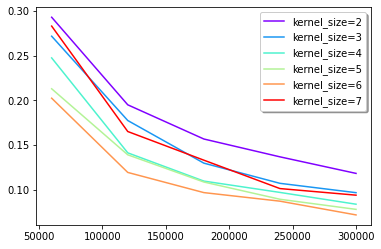

In [15]:
colors = cm.rainbow(np.linspace(0, 1, len(first_experiment_test_losses)))

idx = 2
fig, ax = plt.subplots()
for loss, color in zip(first_experiment_test_losses, colors):
    ax.plot(test_counter[1:], loss[1:], color=color, label='kernel_size=' + str(idx))
    idx += 1
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

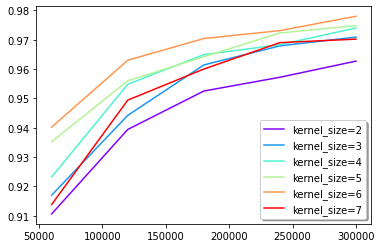

In [17]:
idx = 2
fig, ax = plt.subplots()
for acc, color in zip(first_experiment_accuracies, colors):
    ax.plot(test_counter[1:], acc[1:], color=color, label='kernel_size=' + str(idx))
    idx += 1
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-2: The number of convolution filters in a layer
#### Hypothesis
More kernels in the first convolutional layer should learn more features and increase the accuracy, and it should take more time for training.
#### Observation
I tried the kernel numbers: 5, 7, 9, 11, 13, 15 for the first convolutional layer. The result shows the model with 13 kernels get the best performance and the model with 9 kernels get the worst performance. The accuracy of the other four models are all around 97.2%. Taking the training time into account, I would suggest the 7 or 13 is the best choice.

first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\1867984398.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3265, Accuracy: 480/10000 (5%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319183
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298426
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.304939
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.282966
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266439
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.261481
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.235805
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.265784
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.184918
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.195684
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.160253
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.091599
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.029926
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.975807
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.657228
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.818716
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.506171
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.601846
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.651903
Train Epoch: 1 [12160/6

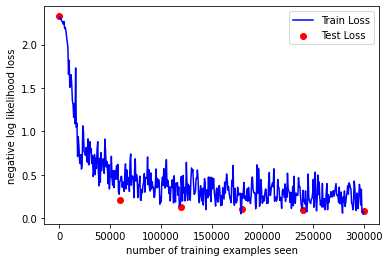


Test set: Avg. loss: 2.3011, Accuracy: 1042/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308023
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.261867
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298213
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.278423
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.251770
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.256877
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.249215
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.226039
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.104551
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.147304
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.968821
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.959096
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.882198
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.716836
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.369864
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.633188
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.506588
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.354707
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.418302
Train Epoch: 1 [12160

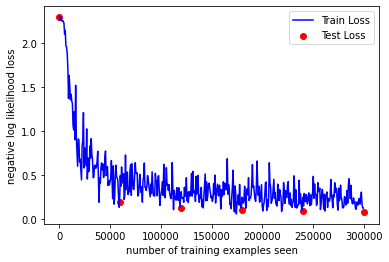


Test set: Avg. loss: 2.3134, Accuracy: 1006/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316177
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304162
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.310784
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.265229
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266444
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.224653
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.232353
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.246584
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.199875
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.161591
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.079150
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.121476
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.987564
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.005336
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.599375
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.746489
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.432479
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.530123
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.570555
Train Epoch: 1 [12160

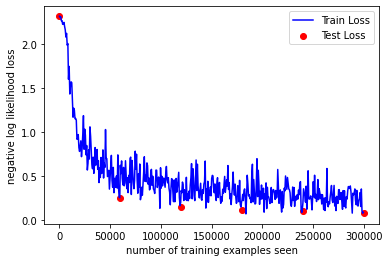


Test set: Avg. loss: 2.3044, Accuracy: 1026/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330158
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.283594
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.316631
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.292063
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.279118
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231660
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.213793
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.177962
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.129235
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.048658
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.963354
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.943933
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.818030
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.776280
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.579152
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.544537
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.600940
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.388691
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.514868
Train Epoch: 1 [12160

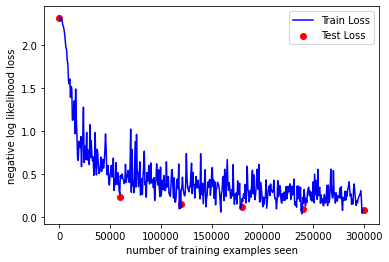


Test set: Avg. loss: 2.3039, Accuracy: 983/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292459
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.282056
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300068
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.219316
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.234673
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.216091
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.178370
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.128094
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.174583
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.063357
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.005439
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.922256
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.796758
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.534066
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.393360
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.666487
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.520413
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.149238
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.388893
Train Epoch: 1 [12160/

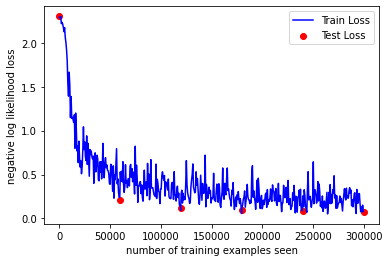


Test set: Avg. loss: 2.3097, Accuracy: 1139/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333638
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.324106
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.351006
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.290589
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241321
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.313357
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.208583
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.122125
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.095412
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.057820
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.981096
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.957107
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.695123
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.645699
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.371709
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.426753
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.431000
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.406874
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.304018
Train Epoch: 1 [12160

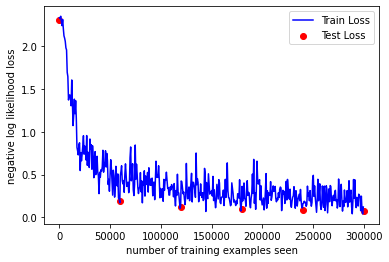

In [19]:
second_experiment_models = [BaseLineModel(kernel_num=i) for i in range(5, 17, 2)]
second_experiment_test_losses = []
second_experiment_accuracies = []
second_experiment_avg_time = []
for model in second_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp2_{model.kernel_num}', f'exp2_{model.kernel_num}_opt')
    second_experiment_test_losses.append(test_losses)
    second_experiment_accuracies.append(accuracies)
    second_experiment_avg_time.append(average_time)

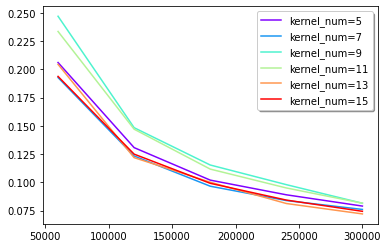

In [20]:
second_experiment_list = [i for i in range(5, 17, 2)]
colors = cm.rainbow(np.linspace(0, 1, len(second_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, kernel_num in zip(second_experiment_test_losses, colors, second_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='kernel_num=' + str(kernel_num))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

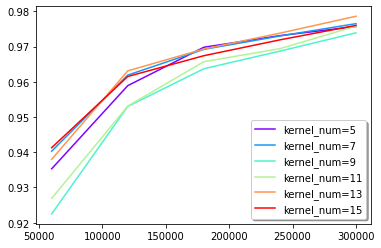

In [21]:
fig, ax = plt.subplots()
for acc, color, kernel_num in zip(second_experiment_accuracies, colors, second_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='kernel_num=' + str(kernel_num))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

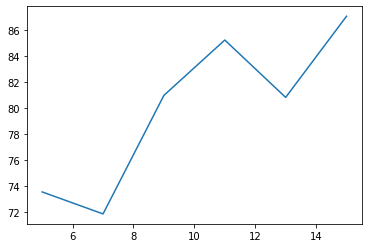

In [22]:
plt.plot(second_experiment_list, second_experiment_avg_time)
plt.show()

---
# Experiment-3: The dropout rates of the Dropout layer
#### Hypothesis
More neural kept should increase the accuracy of the model in out task.
#### Observation
The accuracy decreases when the dropout rate increases, 0.2 dropout rate model perform almost as good as no dropout rate model and the one with 0.8 dropout rate really does a poor job. Moreover, the model with 1.0 as the dropout rate does not learn anything. Since there is no over-fitting happens in our task, more neural should contribute more to the output. Thus, small dropout rate should be a good choice here.

first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\1867984398.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312652
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304152
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.289766
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275011
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.255087
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248024
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.207659
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.204142
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.091976
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.098542
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.979728
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.851581
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838109
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.519915
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.180249
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.253494
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.136639
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.860617
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.240572
Train Epoch: 1 [12160/6

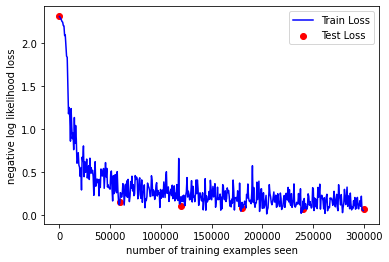


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304919
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.329277
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299756
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.270958
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.269724
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.276621
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.258062
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.222609
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.177263
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.125158
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.114125
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.033540
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.960702
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.766847
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.609167
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.527238
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.669949
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.299707
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.323035
Train Epoch: 1 [12160/6

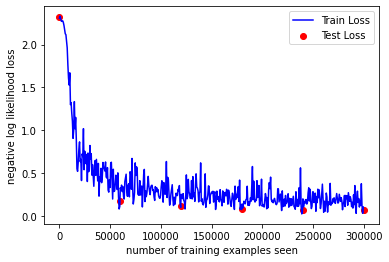


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315758
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305407
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.277434
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.293227
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.287288
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.284051
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.265632
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.251065
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.216119
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.151258
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.217300
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.117073
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.073348
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.029702
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.934954
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.889686
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.634317
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.635403
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.442788
Train Epoch: 1 [12160/6

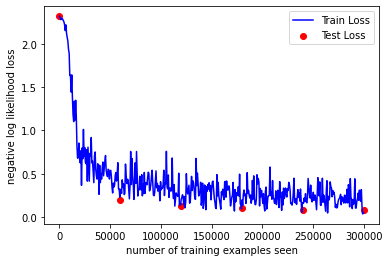


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335629
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.315067
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.308491
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.255120
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.276457
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.282802
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.275388
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.267604
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.277090
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.248966
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.224540
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.223547
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.193171
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.086496
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.118982
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.119362
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.953820
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.959708
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.820644
Train Epoch: 1 [12160/6

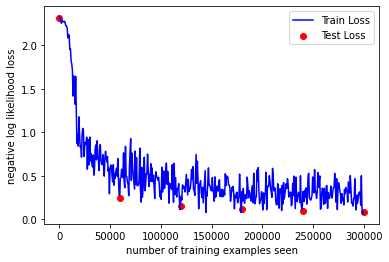


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327799
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.370741
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.286077
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.295852
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301322
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.290308
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.289682
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.301652
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.250982
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.248570
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.251163
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.240939
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.208274
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.219905
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.201552
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.158047
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.207264
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.152625
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.043558
Train Epoch: 1 [12160/6

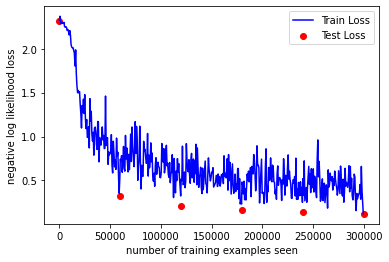


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313188
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295847
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300795
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.303666
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302727
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.296166
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.311142
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.301802
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.308154
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.298151
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.303587
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.308706
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.301406
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.301339
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.305773
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.316147
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.291918
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.300239
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.305065
Train Epoch: 1 [12160/6

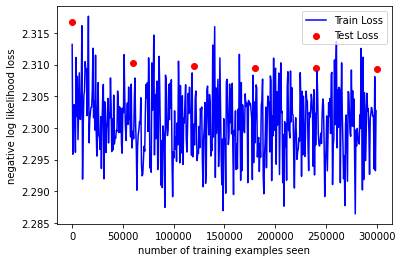

In [24]:
third_experiment_models = [BaseLineModel(dropout_rate=i) for i in np.arange(0.0, 1.2, 0.2)]
third_experiment_test_losses = []
third_experiment_accuracies = []
third_experiment_avg_time = []
for model in third_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp3_{model.dropout_rate}', f'exp3_{model.dropout_rate}_opt')
    third_experiment_test_losses.append(test_losses)
    third_experiment_accuracies.append(accuracies)
    third_experiment_avg_time.append(average_time)

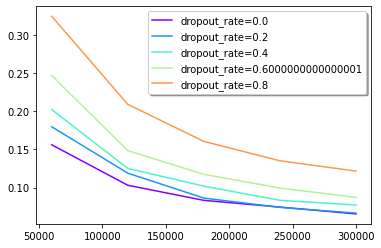

In [27]:
third_experiment_list = [i for i in np.arange(0.0, 1.2, 0.2)]
colors = cm.rainbow(np.linspace(0, 1, len(third_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, dropout_rate in zip(third_experiment_test_losses[:-1], colors[:-1], third_experiment_list[:-1]):
    ax.plot(test_counter[1:], loss[1:], color=color, label='dropout_rate=' + str(dropout_rate))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

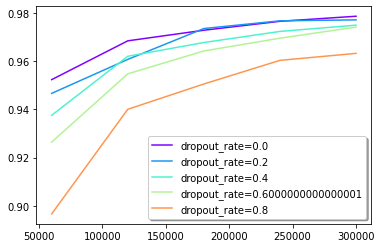

In [30]:
fig, ax = plt.subplots()
for acc, color, dropout_rate in zip(third_experiment_accuracies[:-1], colors[:-1], third_experiment_list[:-1]):
    ax.plot(test_counter[1:], acc[1:], color=color, label='dropout_rate=' + str(dropout_rate))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-4: The size of the pooling layer filters
#### Hypothesis
Bigger the pooling filter size is, smaller the accuracy should be, quicker the training process should be.
#### Observation
Models with pooling size as 2 and 3 are almost same, the one with 4 as the pooling size performs worse, only around 93% comparing with 96% for the other two. Also, since the bigger pooling size could shrink the data faster, the training time is shorter with the increase of the pooling size.

first full connected layer input size: 320
first full connected layer input size: 80
first full connected layer input size: 20


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\112122381.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3110, Accuracy: 1019/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313776
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.344302
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.257346
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.292558
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.282867
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.238557
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.268465
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.257268
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.256329
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.257458
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.137015
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.148898
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.144089
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.118795
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.975661
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.050376
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.965588
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.960572
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.889031
Train Epoch: 1 [12160

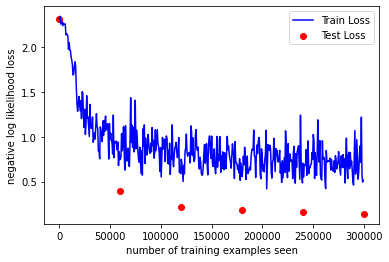


Test set: Avg. loss: 2.3165, Accuracy: 996/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320775
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.346093
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.310082
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.309931
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.305880
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.280710
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.257413
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.276492
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.289410
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.284202
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.262593
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.238579
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.212173
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.234860
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.218278
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.210627
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.208169
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.219449
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.233636
Train Epoch: 1 [12160/

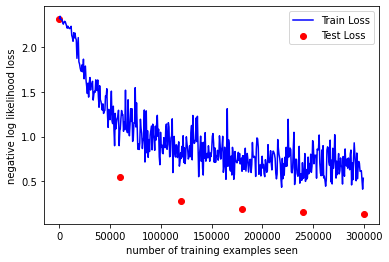


Test set: Avg. loss: 2.3047, Accuracy: 1267/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.356665
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.251774
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.336662
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296886
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.281722
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.311093
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.292756
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.265744
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.284022
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.281352
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.258363
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.242484
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.265284
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.235492
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.218671
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.236592
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.218406
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.178740
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.179532
Train Epoch: 1 [12160

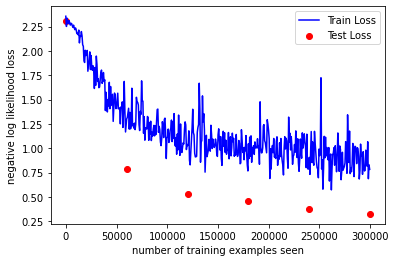

In [39]:
# When pool size euqals to 4, the input size for the first linear layer is 20, thus I have to keep the output of the linear layer as 15 here.
fourth_experiment_models = [BaseLineModel(pool_size=i, hidden_nodes=15) for i in range(2, 5, 1)]
fourth_experiment_test_losses = []
fourth_experiment_accuracies = []
fourth_experiment_avg_time = []
for model in fourth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp4_{model.pool_size}', f'exp4_{model.pool_size}_opt')
    fourth_experiment_test_losses.append(test_losses)
    fourth_experiment_accuracies.append(accuracies)
    fourth_experiment_avg_time.append(average_time)

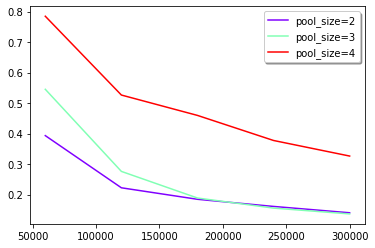

In [43]:
fourth_experiment_list = [i for i in range(2, 5, 1)]
colors = cm.rainbow(np.linspace(0, 1, len(fourth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, pool_size in zip(fourth_experiment_test_losses, colors, fourth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='pool_size=' + str(pool_size))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

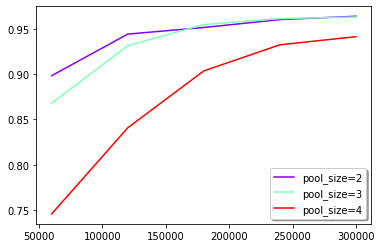

In [44]:
fig, ax = plt.subplots()
for acc, color, pool_size in zip(fourth_experiment_accuracies, colors, fourth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='pool_size=' + str(pool_size))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

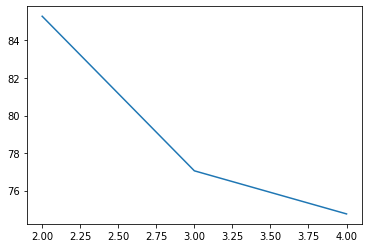

In [45]:
plt.plot(fourth_experiment_list, fourth_experiment_avg_time)
plt.show()

---
# Experiment-5: The activation function for each layer
#### Hypothesis
The tanh and ReLU should perform well, while the softmax and sigmoid may perform poorly.
#### Observation
The tanh and ReLu could be interchangeable, while the softmax and sigmoid really make the training failed. The reason could be the sigmoid and softmax saturates for large positive or large negative values, which leads to small gradients that are almost zeros and those small gradients may vanish during back-propagation.

first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation_func(F.max_pool2d(self.conv1(x), self.pool_size))
C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation_func(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation_func(self.fc1(x))
C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3095, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312951
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.297215
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300319
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.306494
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.298844
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.302350
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.310250
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.303070
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.309211
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.298477
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300783
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.311151
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.306341
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.302371
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.306505
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.311237
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.292468
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.300916
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.314595
Train Epoch: 1 [12160/

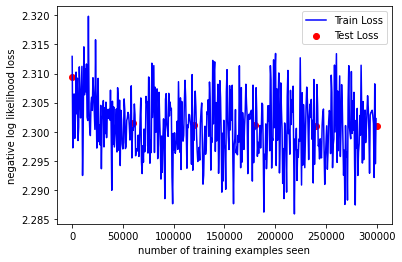


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302679
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.316456
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.290901
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.292747
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295236
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.298884
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.275263
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.260741
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.259835
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.203615
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.204626
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.191003
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.206832
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.981888
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.971402
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.752032
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.846568
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.603461
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.731460
Train Epoch: 1 [12160/6

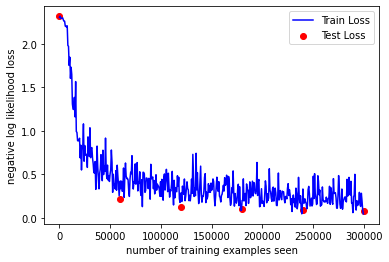

C:\Users\stard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



Test set: Avg. loss: 2.3249, Accuracy: 827/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332768
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299364
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.268342
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.230419
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.225349
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.214049
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.170419
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.122938
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.070379
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.083322
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.075436
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.978857
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.954558
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.854101
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.753311
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.751286
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.809383
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.691439
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.683359
Train Epoch: 1 [12160/6

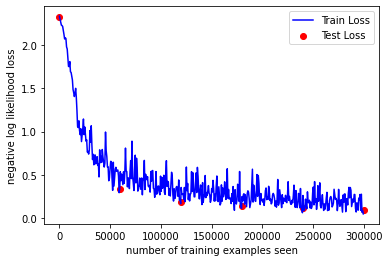

C:\Users\stard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 2.3369, Accuracy: 1028/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307694
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.457604
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.306078
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.318969
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.328711
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.264818
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.368514
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.335073
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.300706
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.299960
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.317388
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.278960
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.364099
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.316296
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.284806
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.354741
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.316790
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.354488
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.324034
Train Epoch: 1 [12160

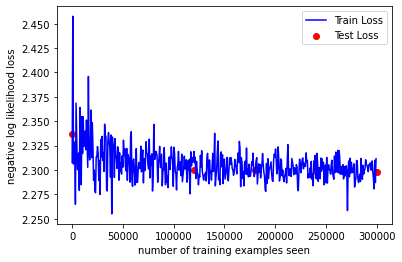

In [51]:
fifth_experiment_models = [BaseLineModel(activation_func=f) for f in [F.softmax, F.relu, F.tanh, F.sigmoid]]
fifth_experiment_test_losses = []
fifth_experiment_accuracies = []
fifth_experiment_avg_time = []
for model in fifth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp5_{model.activation_func.__name__}', f'exp5_{model.activation_func.__name__}_opt')
    fifth_experiment_test_losses.append(test_losses)
    fifth_experiment_accuracies.append(accuracies)
    fifth_experiment_avg_time.append(average_time)

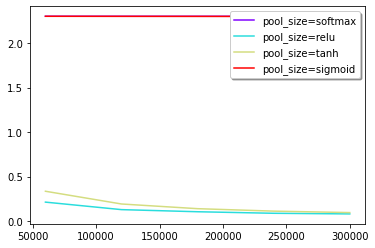

In [53]:
fifth_experiment_list = [F.softmax, F.relu, F.tanh, F.sigmoid]
colors = cm.rainbow(np.linspace(0, 1, len(fifth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, f in zip(fifth_experiment_test_losses, colors, fifth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='pool_size=' + f.__name__)
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

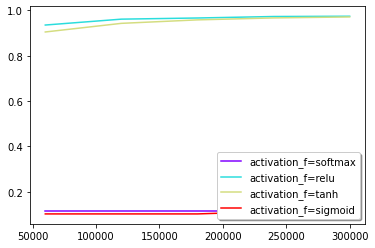

In [54]:
fig, ax = plt.subplots()
for acc, color, func in zip(fifth_experiment_accuracies, colors, fifth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='activation_f=' + str(func.__name__))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-6: The number of hidden nodes in the Dense layer
#### Hypothesis
It is hard to determine the optimal value for the hidden nodes number. There are loads of empirically-derived rules-of-thumb discussing about the choice of hidden nodes number in a network. From Jeff Heaton's saying: "he optimal size of the hidden layer is usually between the size of the input and size of the output layers". Thus, I would say the number around 170 should not perform bad.
#### Observation
From the accuracy plot, you could see the one with 30 hidden nodes perform worse than the others. The models with node number 180 or 230 or 280 perform fairly good and almost the same. Thus, I would say 180 would be my choice when training since it could reduce the dimension to a greater extent.

first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2996, Accuracy: 1772/10000 (18%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309464
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307947
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.312954
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.267472
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266976
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.234262
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.215850
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.163286
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.179984
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.100480
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.002125
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.000198
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.018816
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.735313
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.641315
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.645424
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.674464
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.563349
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.437071
Train Epoch: 1 [12160

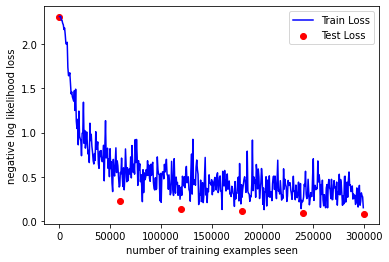


Test set: Avg. loss: 2.3084, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286492
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279180
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.296846
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.226640
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.243548
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.221387
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.185709
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.120237
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.077393
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.007331
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.808863
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.862407
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.695128
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.422781
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.130201
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.454118
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.125261
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.340032
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.075436
Train Epoch: 1 [12160/

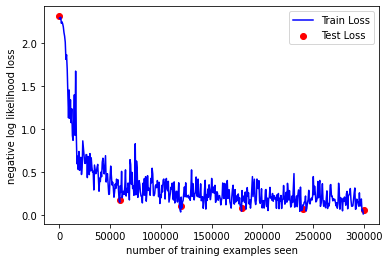


Test set: Avg. loss: 2.3024, Accuracy: 1253/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305673
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.310392
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299260
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272524
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.272356
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.228913
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.216141
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.117437
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.139643
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.065497
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.930178
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.788823
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.632143
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.569893
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.223467
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.212526
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.359050
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.020830
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.148806
Train Epoch: 1 [12160

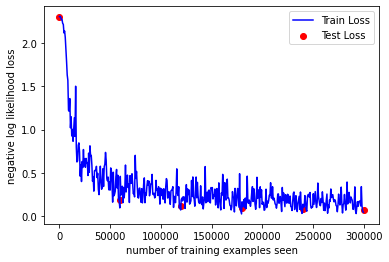


Test set: Avg. loss: 2.3148, Accuracy: 1262/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331918
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.306401
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.312235
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296148
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.289782
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.262154
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.207150
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.185044
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.141003
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.098074
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.078717
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.953315
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.810429
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.471040
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.246405
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.412183
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.364470
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.125164
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.404867
Train Epoch: 1 [12160

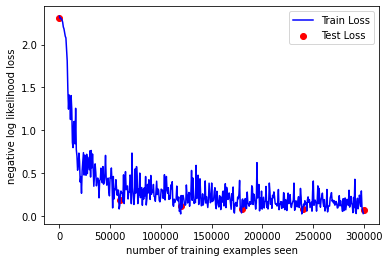


Test set: Avg. loss: 2.3021, Accuracy: 1693/10000 (17%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302217
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304355
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.319260
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.263513
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.252015
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.258647
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.156768
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.124481
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.053658
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.012579
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.871649
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.823202
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.875823
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.426273
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.208835
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.249635
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.295687
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.169918
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.317620
Train Epoch: 1 [12160

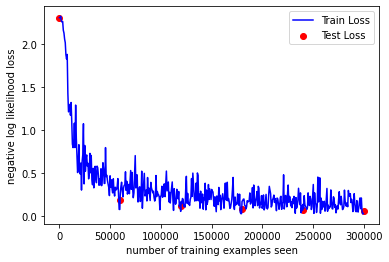


Test set: Avg. loss: 2.3074, Accuracy: 992/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328886
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.275900
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.277934
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.252369
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.191518
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.244371
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.232086
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.085982
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.042042
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.767724
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.693475
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.588755
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.400355
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.178201
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.020333
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.006172
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.222027
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.888319
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.334420
Train Epoch: 1 [12160/

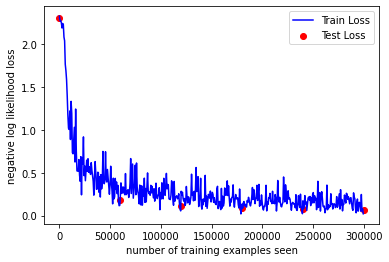

In [55]:
sixth_experiment_models = [BaseLineModel(hidden_nodes=i) for i in range(30, 320, 50)]
sixth_experiment_test_losses = []
sixth_experiment_accuracies = []
sixth_experiment_avg_time = []
for model in sixth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp6_{model.hidden_nodes}', f'exp6_{model.hidden_nodes}_opt')
    sixth_experiment_test_losses.append(test_losses)
    sixth_experiment_accuracies.append(accuracies)
    sixth_experiment_avg_time.append(average_time)

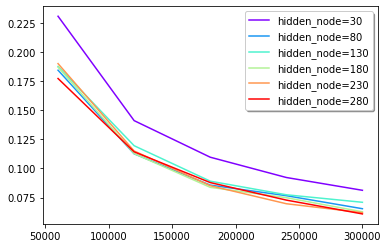

In [56]:
sixth_experiment_list = [i for i in range(30, 320, 50)]
colors = cm.rainbow(np.linspace(0, 1, len(sixth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, hidden_node in zip(sixth_experiment_test_losses, colors, sixth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='hidden_node=' + str(hidden_node))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

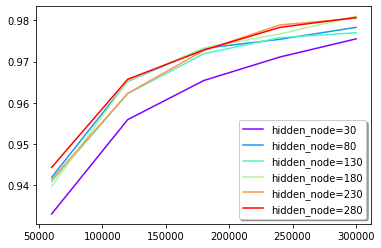

In [58]:
fig, ax = plt.subplots()
for acc, color, hidden_node in zip(sixth_experiment_accuracies, colors, sixth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='hidden_node=' + str(hidden_node))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-7: The number of epochs of training
#### Hypothesis
The number of epoch could help increase the accuracy, while it does not change much after the model converges.
#### Observation
I set the number of epoch as 8 and the results shows the loss is quite small after the second or third epoch, which is because the training dataset is quite small for this task. The training epoch after that does help to reduce the loss value, but it really does not change much.

first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335315
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299947
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291813
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.289917
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.286746
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.280502
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.270755
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.245888
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.201029
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.232131
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.203217
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.197560
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.150122
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.038775
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.913650
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.937729
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.918656
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.792339
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.780283
Train Epoch: 1 [12160/6

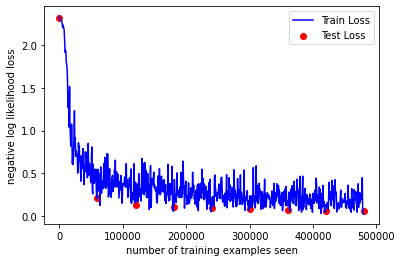

In [59]:
large_epoch_model = BaseLineModel(training_epoch=8)
train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(large_epoch_model, 'exp7', 'exp7')

---
# Experiment-8: The batch size while training
#### Hypothesis
Bigger the batch size, smaller accuracy the model should perform, faster the training process.
#### Observation
With the increase of the batch size, the accuracy of the model decrease. Also, the model with smaller batch size converges faster than the bigger ones. As for the training time, bigger batch size means less update during training, which obviously decrease the time for training. However, the batch_size=32 model spent more time on training than batch_size=16, which should be a spike due to the small size of dataset.

first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320
first full connected layer input size: 320


C:\Users\stard\AppData\Local\Temp\ipykernel_25584\754541068.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.468716
Train Epoch: 1 [80/60000 (0%)]	Loss: 2.313424
Train Epoch: 1 [160/60000 (0%)]	Loss: 2.321327
Train Epoch: 1 [240/60000 (0%)]	Loss: 2.295887
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.225901
Train Epoch: 1 [400/60000 (1%)]	Loss: 2.299180
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.320870
Train Epoch: 1 [560/60000 (1%)]	Loss: 2.318887
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295659
Train Epoch: 1 [720/60000 (1%)]	Loss: 2.311362
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.277371
Train Epoch: 1 [880/60000 (1%)]	Loss: 1.962013
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.191409
Train Epoch: 1 [1040/60000 (2%)]	Loss: 2.012486
Train Epoch: 1 [1120/60000 (2%)]	Loss: 2.020334
Train Epoch: 1 [1200/60000 (2%)]	Loss: 1.903756
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.950810
Train Epoch: 1 [1360/60000 (2%)]	Loss: 1.899738
Train Epoch: 1 [1440/60000 (2%)]	Loss: 1.989074
Train Epoch: 1 [1520/60000 (3%)]	Loss: 1.488059


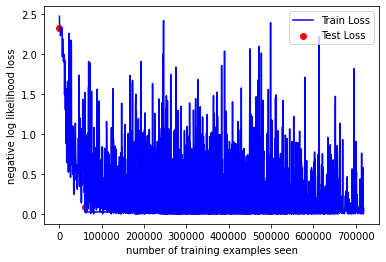


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.358517
Train Epoch: 1 [160/60000 (0%)]	Loss: 2.340415
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.298656
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.328661
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.227343
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.248669
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.279137
Train Epoch: 1 [1120/60000 (2%)]	Loss: 2.318325
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.211379
Train Epoch: 1 [1440/60000 (2%)]	Loss: 2.215297
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.198544
Train Epoch: 1 [1760/60000 (3%)]	Loss: 2.194412
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.223858
Train Epoch: 1 [2080/60000 (3%)]	Loss: 1.996012
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.108742
Train Epoch: 1 [2400/60000 (4%)]	Loss: 2.041391
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.982440
Train Epoch: 1 [2720/60000 (5%)]	Loss: 1.886604
Train Epoch: 1 [2880/60000 (5%)]	Loss: 1.580173
Train Epoch: 1 [3040/60000 (5%)]	Loss: 1.

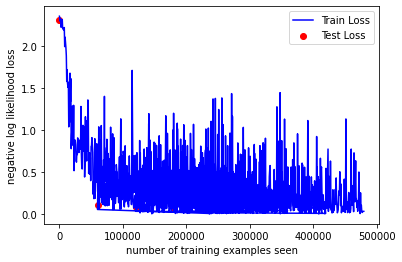


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.367699
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.269289
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.297897
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.275875
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.306996
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.310292
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.291496
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.247901
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.231923
Train Epoch: 1 [2880/60000 (5%)]	Loss: 2.252746
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.193153
Train Epoch: 1 [3520/60000 (6%)]	Loss: 2.158020
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.147214
Train Epoch: 1 [4160/60000 (7%)]	Loss: 2.089707
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.026493
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.946289
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.698458
Train Epoch: 1 [5440/60000 (9%)]	Loss: 1.659379
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.603404
Train Epoch: 1 [6080/60000 (10%)]	Los

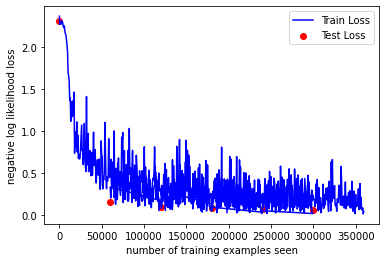


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292068
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.315484
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.284034
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.305944
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301186
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.295020
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.279026
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.281399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.233069
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.224252
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.234777
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.137824
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.196517
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.009302
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.023153
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.995962
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.995239
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.787933
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.567715
Train Epoch: 1 [12160/6

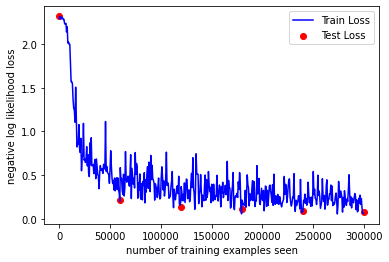


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311667
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.316801
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.307883
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.298434
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.285078
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.275366
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.298994
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.265804
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.252126
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.257823
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.210548
Train Epoch: 1 [14080/60000 (23%)]	Loss: 2.188824
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.127638
Train Epoch: 1 [16640/60000 (28%)]	Loss: 2.043494
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.040551
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.939226
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.866939
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.652356
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.578686
Train Epoc

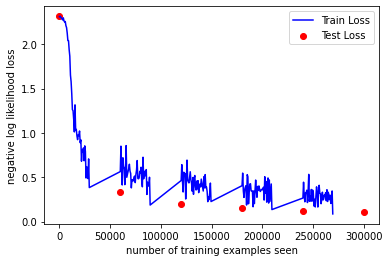

In [63]:
eighth_experiment_models = [BaseLineModel(batch_size=2**i) for i in range(3, 8, 1)]
eighth_experiment_test_losses = []
eighth_experiment_accuracies = []
eighth_experiment_avg_time = []
for model in eighth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp8_{model.batch_size_train}', f'exp8_{model.batch_size_train}_opt')
    eighth_experiment_test_losses.append(test_losses)
    eighth_experiment_accuracies.append(accuracies)
    eighth_experiment_avg_time.append(average_time)

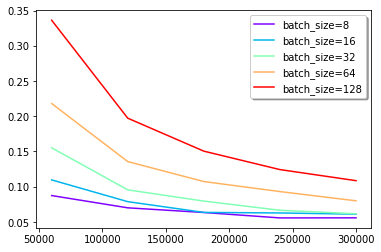

In [66]:
eighth_experiment_list = [2**i for i in range(3, 8, 1)]
colors = cm.rainbow(np.linspace(0, 1, len(eighth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, batch_size in zip(eighth_experiment_test_losses, colors, eighth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='batch_size=' + str(batch_size))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

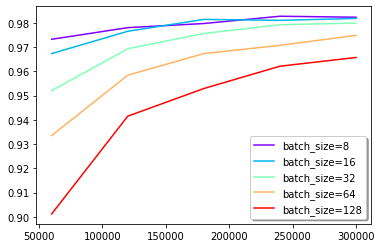

In [68]:
fig, ax = plt.subplots()
for acc, color, batch_size in zip(eighth_experiment_accuracies, colors, eighth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='batch_size=' + str(batch_size))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

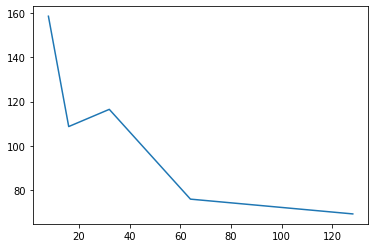

In [69]:
plt.plot(eighth_experiment_list, eighth_experiment_avg_time)
plt.show()